Import Libraries

In [1]:
library(ggplot2)
library(tidyverse)
library(lubridate)
library(leaps)
library(dplyr)
library(glmnet)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ tibble  2.1.3     ✔ purrr   0.3.3
✔ tidyr   1.0.2     ✔ dplyr   0.8.4
✔ readr   1.3.1     ✔ stringr 1.4.0
✔ tibble  2.1.3     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following object is masked from ‘package:base’:

    date


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 3.0-2




Import Data

In [2]:
age_guesser = read.csv('../input/ds5220-ageguesser/ageGuesser.csv', header = T, colClass = c(quality_avg = 'numeric'))
age_guesser$ethnicity_gamer <- as.character(age_guesser$ethnicity_gamer)
age_guesser$ethnicity_gamer[age_guesser$ethnicity_gamer == 'Caucasian/White'] = 'White'
age_guesser$ethnicity_gamer <- as.factor(age_guesser$ethnicity_gamer)
age_guesser$ethnicity_photo <- as.character(age_guesser$ethnicity_photo)
age_guesser$ethnicity_photo[age_guesser$ethnicity_photo == 'Caucasian/White'] = 'White'
age_guesser$ethnicity_photo <- as.factor(age_guesser$ethnicity_photo)

In [3]:
whiteguesser = age_guesser %>% filter(ethnicity_gamer == 'White')
nrow(whiteguesser)/nrow(age_guesser)
whitephoto = age_guesser %>% filter(ethnicity_photo == 'White')
nrow(whitephoto)/nrow(age_guesser)

[1] 0.8318097

[1] 0.847201

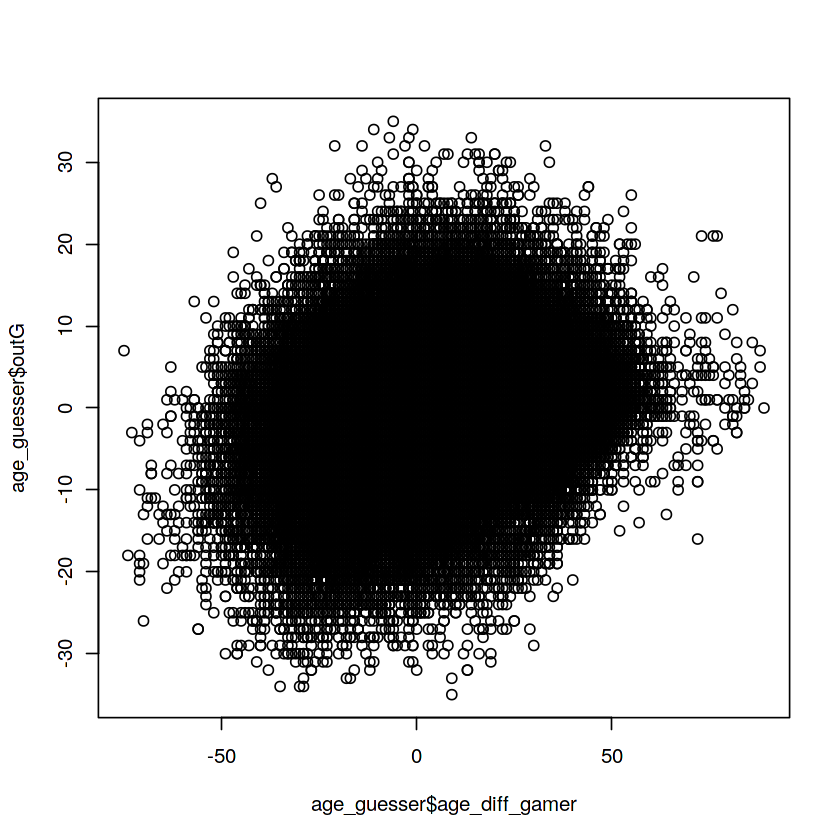

In [4]:
plot(age_guesser$age_diff_gamer, age_guesser$outG)

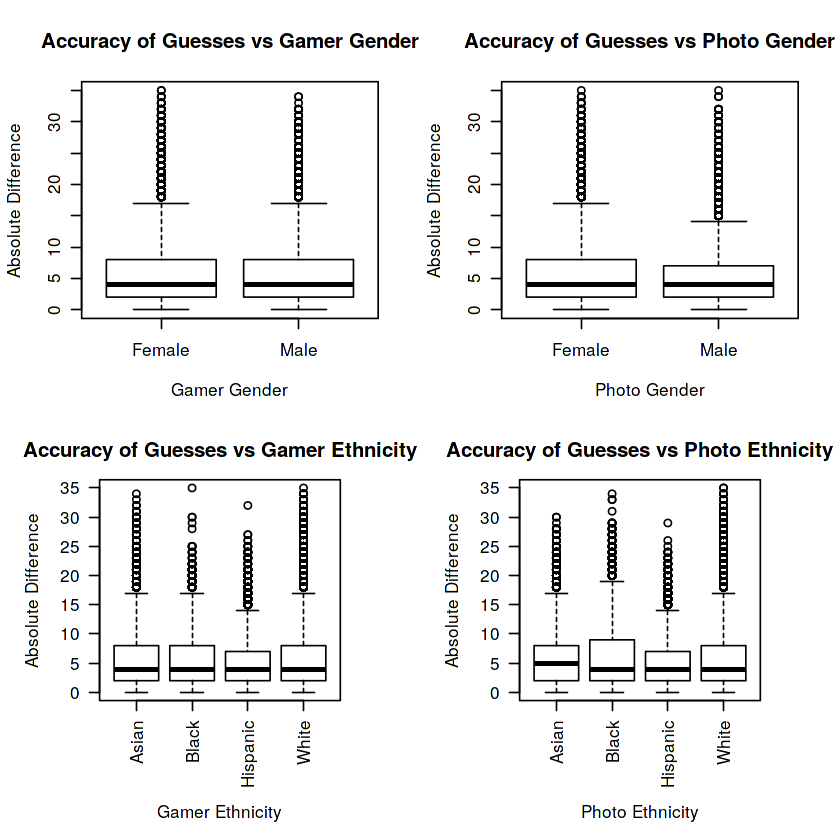

In [5]:
par(mfrow = c(2,2))
plot(age_guesser$gender_gamer, age_guesser$abs_guess_diff, xlab = 'Gamer Gender', ylab = 'Absolute Difference', main = 'Accuracy of Guesses vs Gamer Gender') # identical, female has slightly longer tail.
plot(age_guesser$gender_photo, age_guesser$abs_guess_diff, xlab = 'Photo Gender', ylab = 'Absolute Difference', main = 'Accuracy of Guesses vs Photo Gender') # identical, male has slightly longer tail
par(mar = c(7, 5, 3, 4))
plot(age_guesser$ethnicity_gamer, age_guesser$abs_guess_diff, xlab = '', ylab = 'Absolute Difference', main = 'Accuracy of Guesses vs Gamer Ethnicity', las = 2)
title(xlab = 'Gamer Ethnicity', line = 5)
# mtext(side=1, text = 'Causasian/White', line=0.5)
plot(age_guesser$ethnicity_photo, age_guesser$abs_guess_diff, xlab = '', ylab = 'Absolute Difference', main = 'Accuracy of Guesses vs Photo Ethnicity', las = 2)
title(xlab = 'Photo Ethnicity', line = 5)
# mtext(side=1, text = 'Causasian/White', line=0.5)
# black and asian gamers have slightly positive mean, while black gamers have highest upper whisker. Hispanic gamers gives the least spread out diff
# photos of all ethnicities have identical means but white receives the most spread out guesses, while hispanic gets the least spread out

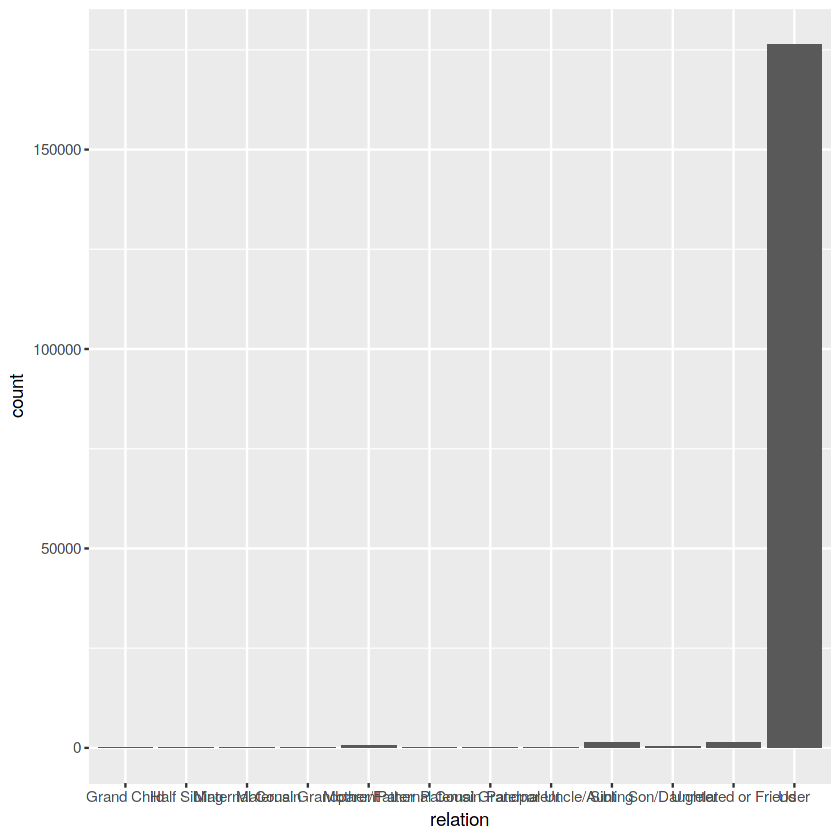

In [6]:
ggplot(age_guesser) + stat_count(mapping = aes(x = relation))

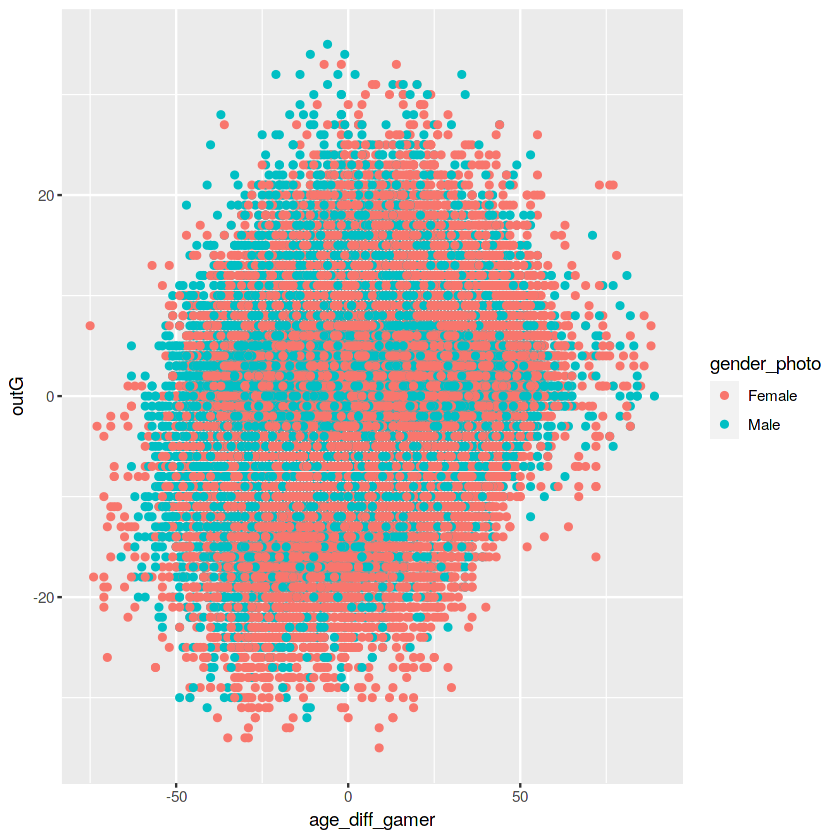

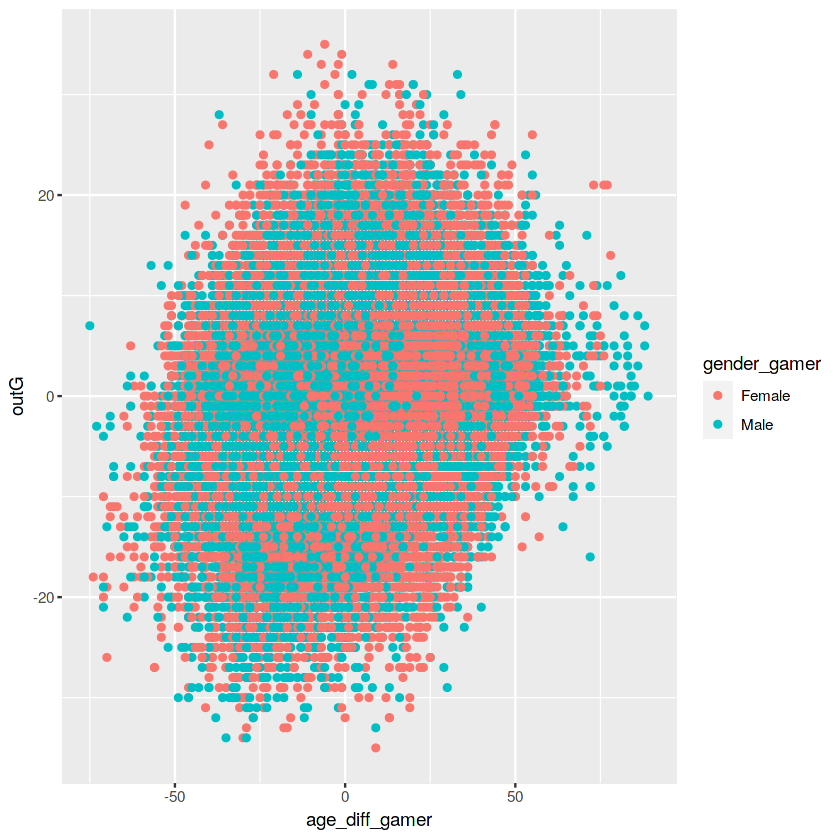

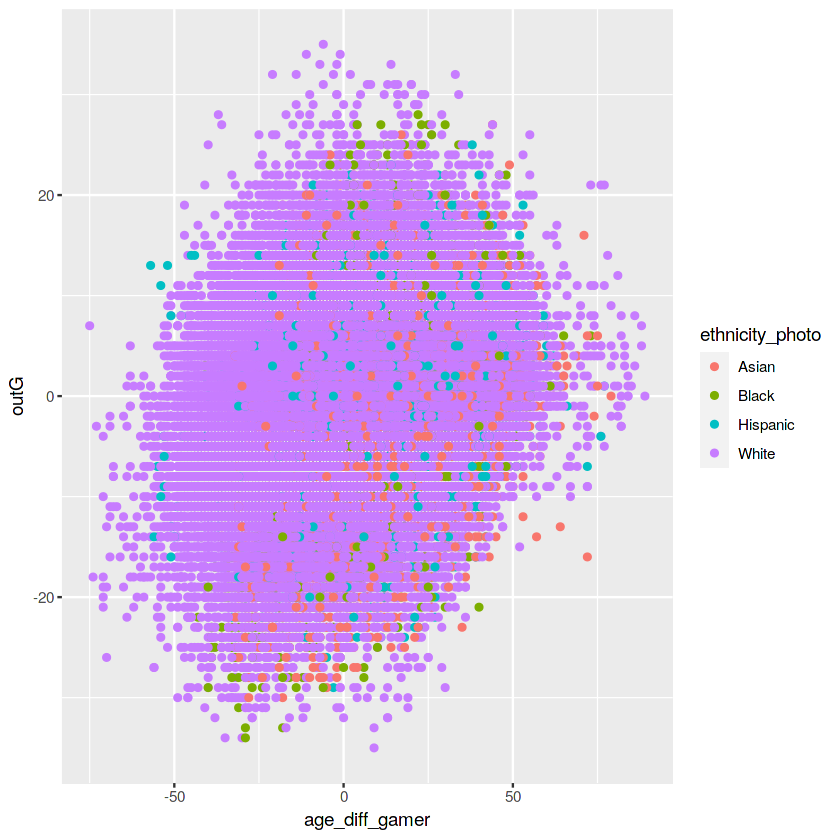

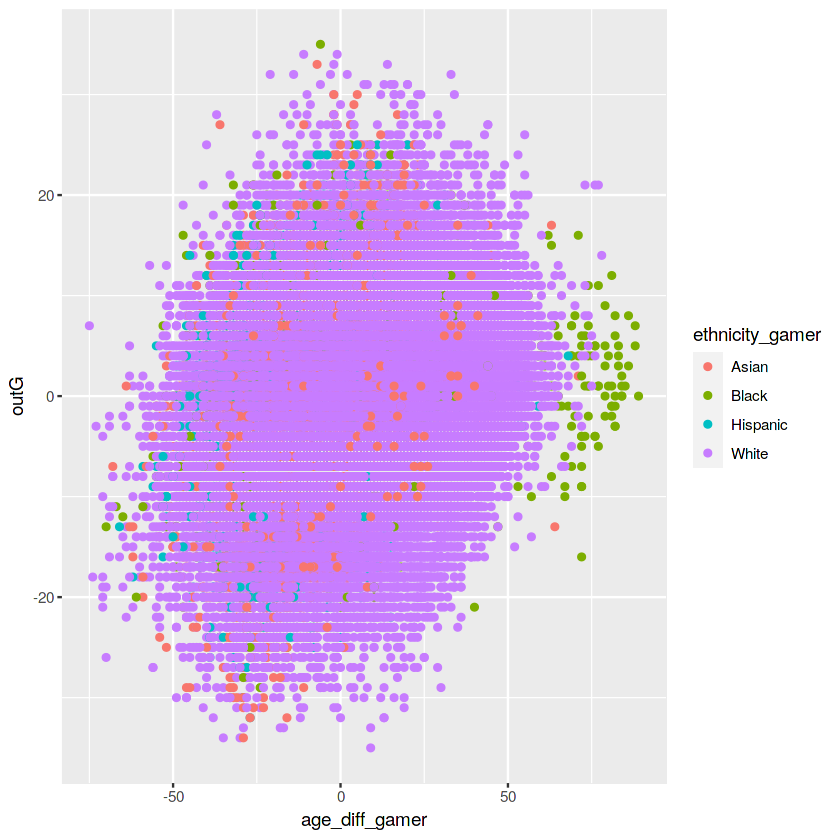

In [7]:
ggplot(data = age_guesser) + geom_point(mapping = aes(x = age_diff_gamer, y = outG, color = gender_photo))
ggplot(data = age_guesser) + geom_point(mapping = aes(x = age_diff_gamer, y = outG, color = gender_gamer))
ggplot(data = age_guesser) + geom_point(mapping = aes(x = age_diff_gamer, y = outG, color = ethnicity_photo))
ggplot(data = age_guesser) + geom_point(mapping = aes(x = age_diff_gamer, y = outG, color = ethnicity_gamer))

# no obviously separated clusters for the last four graphs

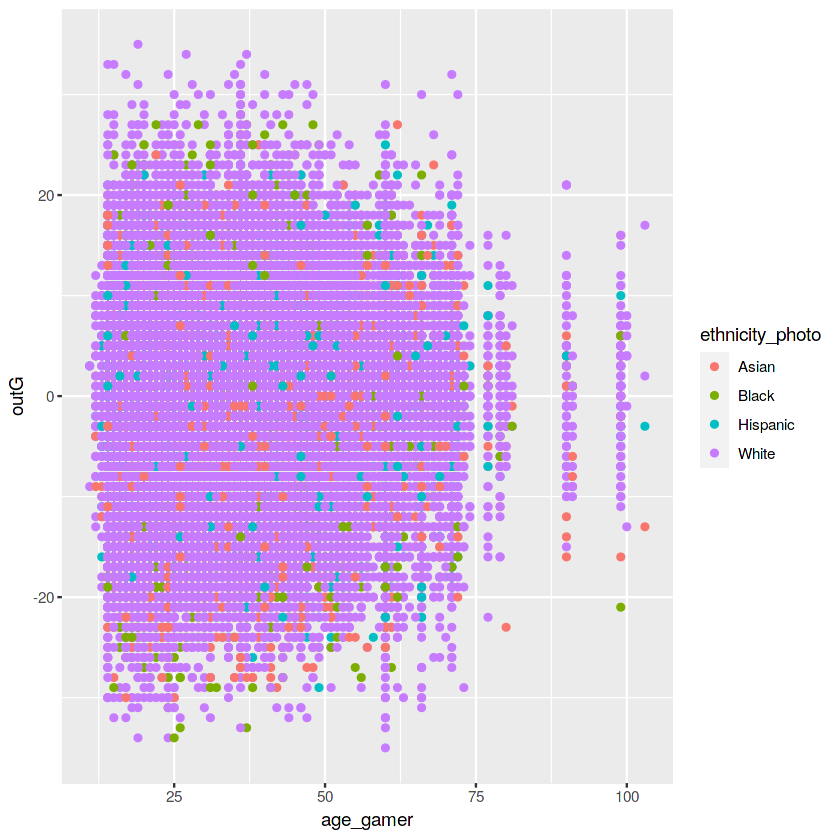

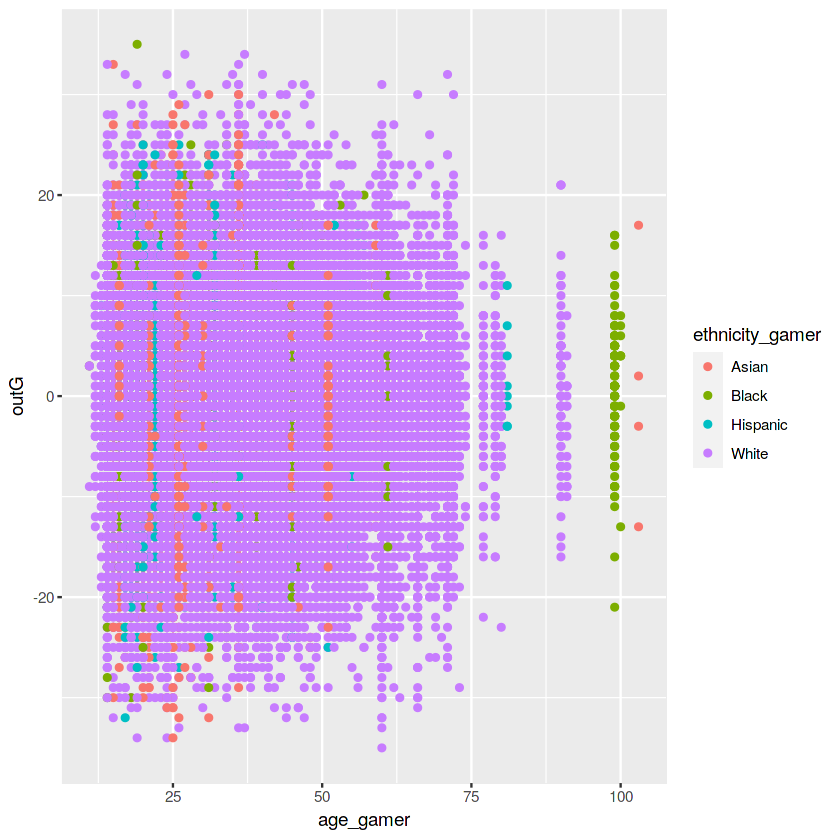

In [8]:
ggplot(data = age_guesser) + geom_point(mapping = aes(x = age_gamer, y = outG, color = ethnicity_photo))
ggplot(data = age_guesser) + geom_point(mapping = aes(x = age_gamer, y = outG, color = ethnicity_gamer))

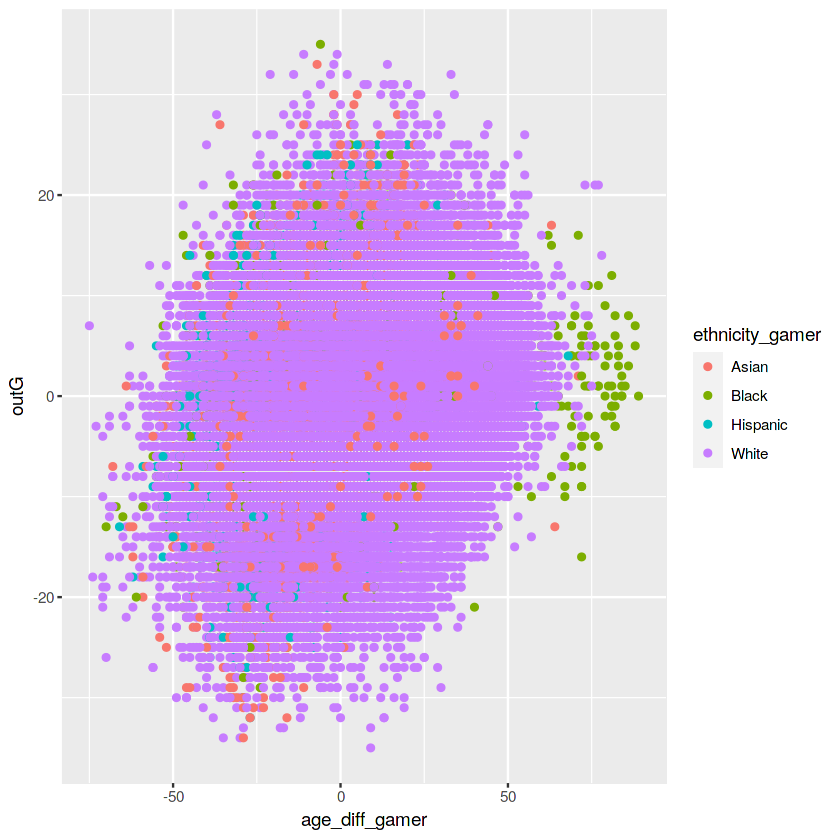

In [9]:
# look at the purple cluster in the graph age_diff_gamer vs outG
bigagediff = age_guesser %>% filter(age_diff_gamer > 70)
# ggplot(data = bigagediff) + geom_point(mapping = aes(x = age_diff_gamer, y = outG, color = ethnicity_gamer))
bigagediff = bigagediff %>% mutate(age_created = year(bigagediff$created) - bigagediff$birth_year_gamer)

# cut off gamers who are over 110 years old and those who are younger than 3
age_guesser = age_guesser %>% filter(age_gamer < 110) %>% filter(age_gamer > 3)
ggplot(data = age_guesser) + geom_point(mapping = aes(x = age_diff_gamer, y = outG, color = ethnicity_gamer))

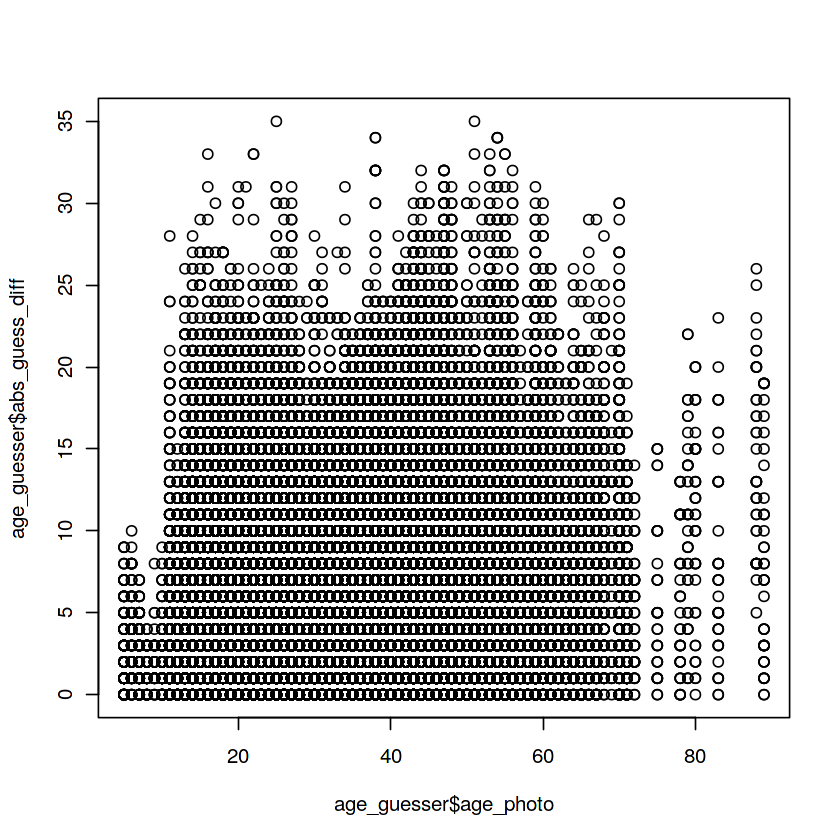

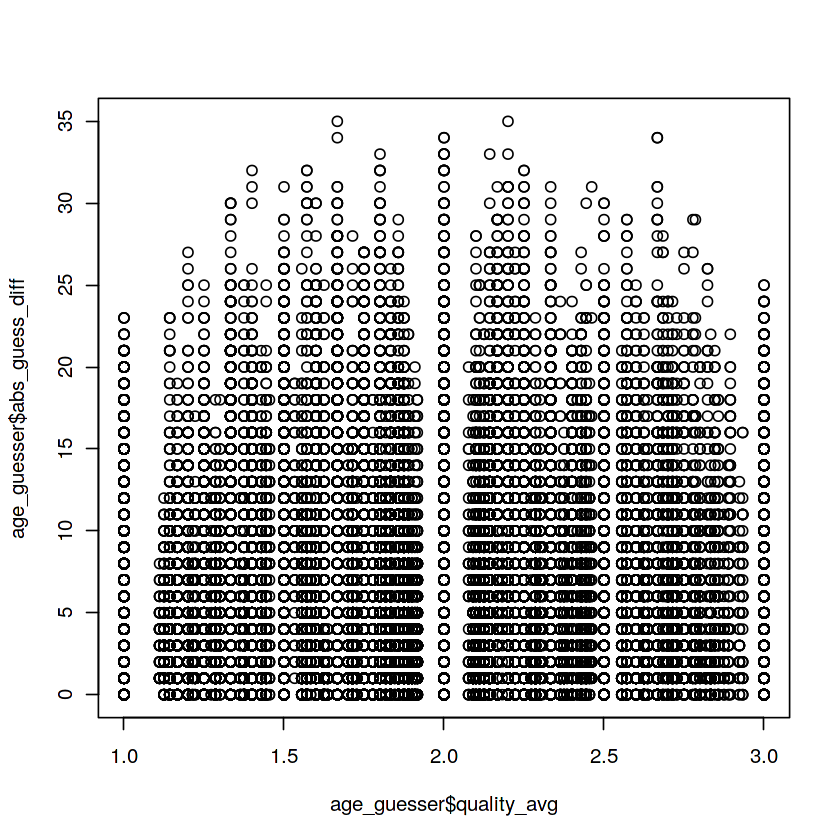

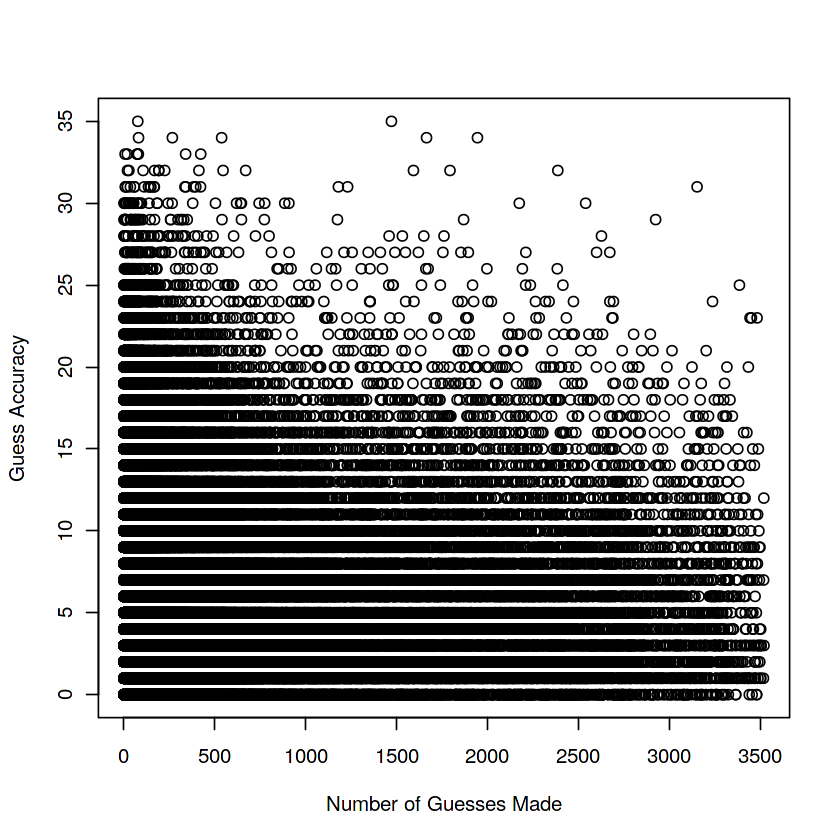

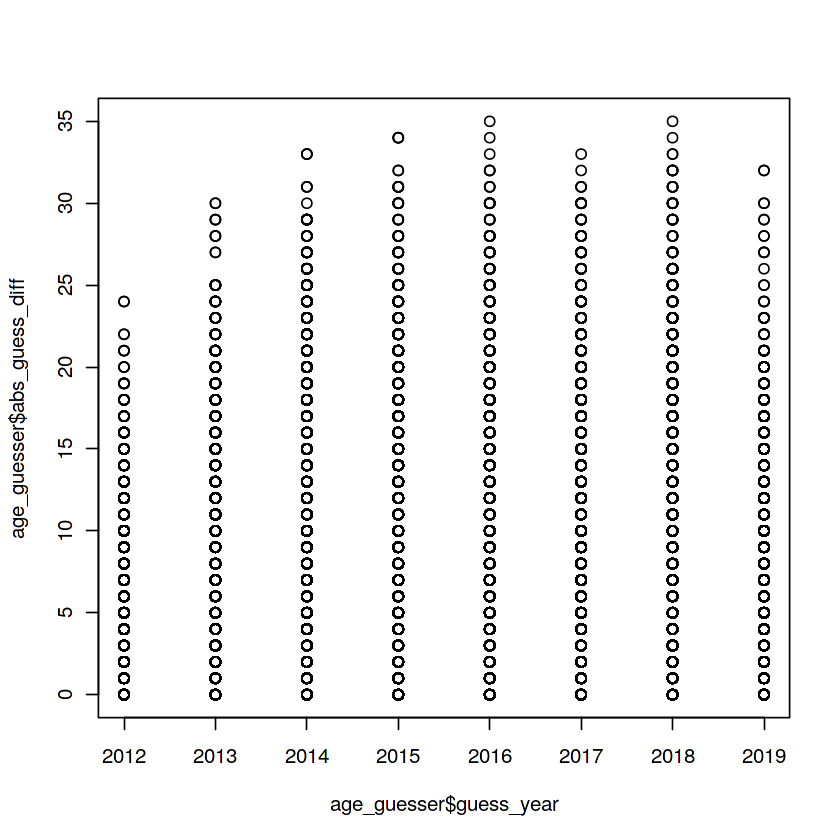

In [10]:
plot(x = age_guesser$age_photo, y = age_guesser$abs_guess_diff)
plot(x = age_guesser$quality_avg, y = age_guesser$abs_guess_diff)
plot(x = age_guesser$num_guesses, y = age_guesser$abs_guess_diff, xlab = 'Number of Guesses Made', ylab = 'Guess Accuracy')
plot(x = age_guesser$guess_year, y = age_guesser$abs_guess_diff)

Linear Regression with Cateogorical Variables

In [11]:
lm.fit = lm(abs_guess_diff ~ 
            age_photo + gender_photo + ethnicity_photo + quality_avg + gender_gamer + ethnicity_gamer + age_diff_gamer + num_guesses + guess_year, 
            age_guesser)
summary(lm.fit)

#Almost all the variables included have significant p-values except "ethnicity_gamerHispanic" and the F-value is huge. However, R-squared is too small.
# It does seem like variable "age_gamer' has the smallest Std.Error, which gives the tightest confidence interval for its estimation. The second tightiest is # variable "age_photo"


Call:
lm(formula = abs_guess_diff ~ age_photo + gender_photo + ethnicity_photo + 
    quality_avg + gender_gamer + ethnicity_gamer + age_diff_gamer + 
    num_guesses + guess_year, data = age_guesser)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.7572  -3.1756  -0.9633   2.2598  30.5827 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)             -2.854e+01  1.184e+01  -2.410 0.015942 *  
age_photo                1.023e-01  1.161e-03  88.070  < 2e-16 ***
gender_photoMale        -6.954e-01  2.134e-02 -32.583  < 2e-16 ***
ethnicity_photoBlack     3.149e-01  7.790e-02   4.043 5.29e-05 ***
ethnicity_photoHispanic -6.888e-01  5.823e-02 -11.828  < 2e-16 ***
ethnicity_photoWhite    -7.415e-01  3.957e-02 -18.738  < 2e-16 ***
quality_avg              8.558e-01  2.416e-02  35.421  < 2e-16 ***
gender_gamerMale        -2.247e-02  2.102e-02  -1.069 0.285176    
ethnicity_gamerBlack     2.638e-01  7.437e-02   3.548 0.000389 ***
ethnicity

In [12]:
# investigate info related to gamers only
lm.fit_gamer = lm(abs_guess_diff ~ gender_gamer + ethnicity_gamer + age_gamer, age_guesser)
summary(lm.fit_gamer)

# several p-value increased with much smaller values for both R2 and F-stats


Call:
lm(formula = abs_guess_diff ~ gender_gamer + ethnicity_gamer + 
    age_gamer, data = age_guesser)

Residuals:
   Min     1Q Median     3Q    Max 
-6.472 -3.378 -1.206  2.475 29.642 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)              5.0092092  0.0427515 117.170  < 2e-16 ***
gender_gamerMale        -0.0326058  0.0217864  -1.497  0.13450    
ethnicity_gamerBlack     0.0768791  0.0761378   1.010  0.31262    
ethnicity_gamerHispanic -0.1695961  0.0610325  -2.779  0.00546 ** 
ethnicity_gamerWhite    -0.1611639  0.0366392  -4.399 1.09e-05 ***
age_gamer                0.0143262  0.0008361  17.135  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.559 on 180486 degrees of freedom
Multiple R-squared:  0.001696,	Adjusted R-squared:  0.001669 
F-statistic: 61.34 on 5 and 180486 DF,  p-value: < 2.2e-16


In [13]:
#investigate info related to photos only
lm.fit_photo = lm(abs_guess_diff ~ age_photo + gender_photo + ethnicity_photo + quality_avg, age_guesser)
summary(lm.fit_photo)

# p values and F-stats are all very significate despite R2 is still very low. Note that R2 from this set is very close to lm.fit (the one I first did)
#seems like overall info from photo has bigger impact on how accurate the guesses are than those from guessers themselves


Call:
lm(formula = abs_guess_diff ~ age_photo + gender_photo + ethnicity_photo + 
    quality_avg, data = age_guesser)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.6074  -3.1959  -0.9643   2.2657  30.6911 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)              2.0342546  0.0631118  32.233  < 2e-16 ***
age_photo                0.0916278  0.0008432 108.669  < 2e-16 ***
gender_photoMale        -0.6986371  0.0213557 -32.714  < 2e-16 ***
ethnicity_photoBlack     0.3170579  0.0779863   4.066 4.79e-05 ***
ethnicity_photoHispanic -0.6878253  0.0583001 -11.798  < 2e-16 ***
ethnicity_photoWhite    -0.7451536  0.0396157 -18.810  < 2e-16 ***
quality_avg              0.8566197  0.0241786  35.429  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.401 on 180485 degrees of freedom
Multiple R-squared:  0.06953,	Adjusted R-squared:  0.06949 
F-statistic:  2248 on 6 and 180485 DF

# Model Selection and Cross-Validation

Set up training and testing sets

In [14]:
set.seed(5)
num_train = nrow(age_guesser) %/% 5 * 4 # 80% of the observations
train = sample(1:nrow(age_guesser), num_train)
test = - train
x = model.matrix(abs_guess_diff ~ 
                age_photo + gender_photo + ethnicity_photo + quality_avg + gender_gamer + ethnicity_gamer + age_diff_gamer + num_guesses + guess_year, 
                age_guesser)
y = age_guesser$abs_guess_diff
modeling_df = age_guesser %>% select(abs_guess_diff, age_photo, gender_photo, ethnicity_photo, quality_avg, 
                                     gender_gamer, ethnicity_gamer, age_diff_gamer, num_guesses, guess_year) 
            # new data frame containing only the variables needed for easier coding

In [15]:
names(age_guesser)

[1] "uid_gamer"                       "photo_id"                       
 [3] "guess_id"                        "ageG"                           
 [5] "outG"                            "access"                         
 [7] "gender_gamer"                    "ethnicity_gamer"                
 [9] "birth_country_gamer"             "birth_year_gamer"               
[11] "guess_year"                      "age_gamer"                      
[13] "uid_photo"                       "age_photo"                      
[15] "relation"                        "gender_photo"                   
[17] "ethnicity_photo"                 "birth_country_photo"            
[19] "birth_year_photo"                "death_age"                      
[21] "created"                         "quality_avg"                    
[23] "abs_guess_diff"                  "guess_above_below"              
[25] "age_diff_gamer"                  "ethnicity_gamer_Caucasian.White"
[27] "ethnicity_gamer_Hispanic"        "ethnicity_gamer_Asian"          
[29] "ethnicity_gamer_Black"           "ethnicity_gamer_Other"          
[31] "ethnicity_photo_Asian"           "ethnicity_photo_Black"          
[33] "ethnicity_photo_Caucasian.White" "ethnicity_photo_Hispanic"       
[35] "ethnicity_photo_Other"           "gender_gamer_Male"              
[37] "gender_gamer_Female"             "gender_photo_Female"            
[39] "gender_photo_Male"               "gen_gamer"                      
[41] "gen_photo"                       "gen_gamer_older"                
[43] "gen_gamer_boomer"                "gen_gamer_genx"                 
[45] "gen_gamer_millenial"             "gen_gamer_genz"                 
[47] "gen_photo_genz"                  "gen_photo_millenial"            
[49] "gen_photo_genx"                  "gen_photo_boomer"               
[51] "gen_photo_older"                 "ethnicity_group"                
[53] "gender_group"                    "age_gen_group"                  
[55] "num_guesses"

# Try Exhaustive Subset Selection 
Didnt work with the same variables I used in the first linear regression analysis

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“1  linear dependencies found”

age_diff_gamer = difference between age_gamer and age_photo, have to get rid of one among the three

In [16]:
# make sure there's no NA for the selected variables
for (c in c('age_photo', 'gender_photo', 'ethnicity_photo', 'quality_avg', 'gender_gamer', 'ethnicity_gamer', 'age_gamer', 'age_diff_gamer')){
    stopifnot(nrow(age_guesser %>% filter(is.na(c))) == 0)
}

In [17]:
# find out which to eliminate among age_gamer, age_photo and age_diff_gamer
model_agegamer = lm(abs_guess_diff ~ age_gamer, data = age_guesser)
model_agephoto = lm(abs_guess_diff ~ age_photo, data = age_guesser)
model_absdiff = lm(abs_guess_diff ~ age_diff_gamer, data = age_guesser)
sum_agegamer = summary(model_agegamer) # impact from age_gamer alone
sum_agephoto = summary(model_agephoto) # impact from age_photo alone
sum_absdiff = summary(model_absdiff) # impact from age_diff_gamer alone

# age_gamer: p-value significant, F-stats smallest - eliminated?
# age_photo: p-value significant - keep
# age_diff_gamer: p-value significant - keep

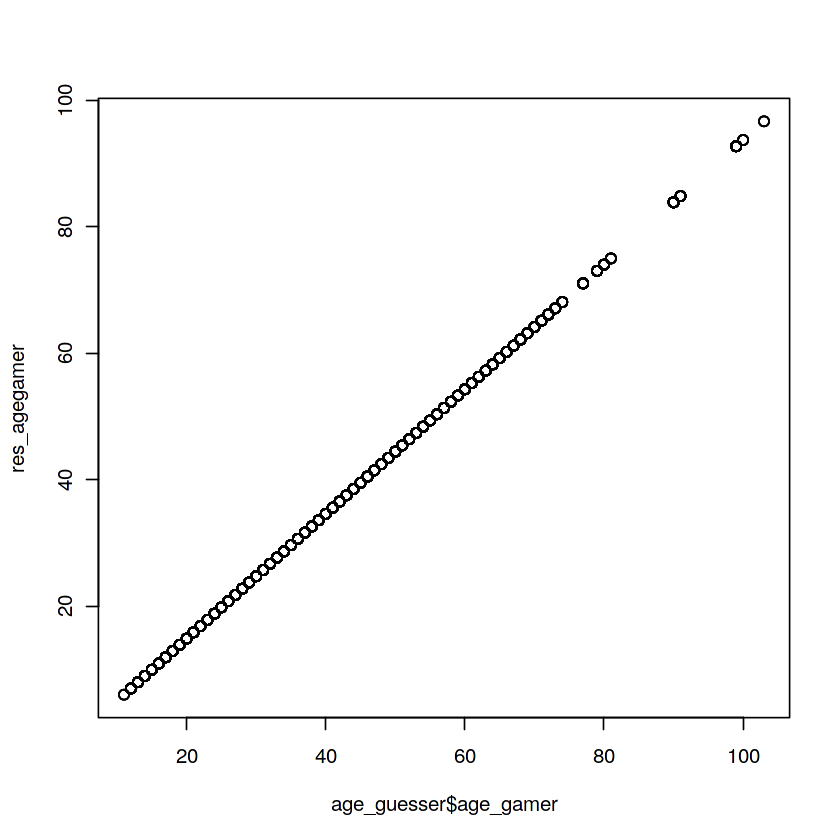

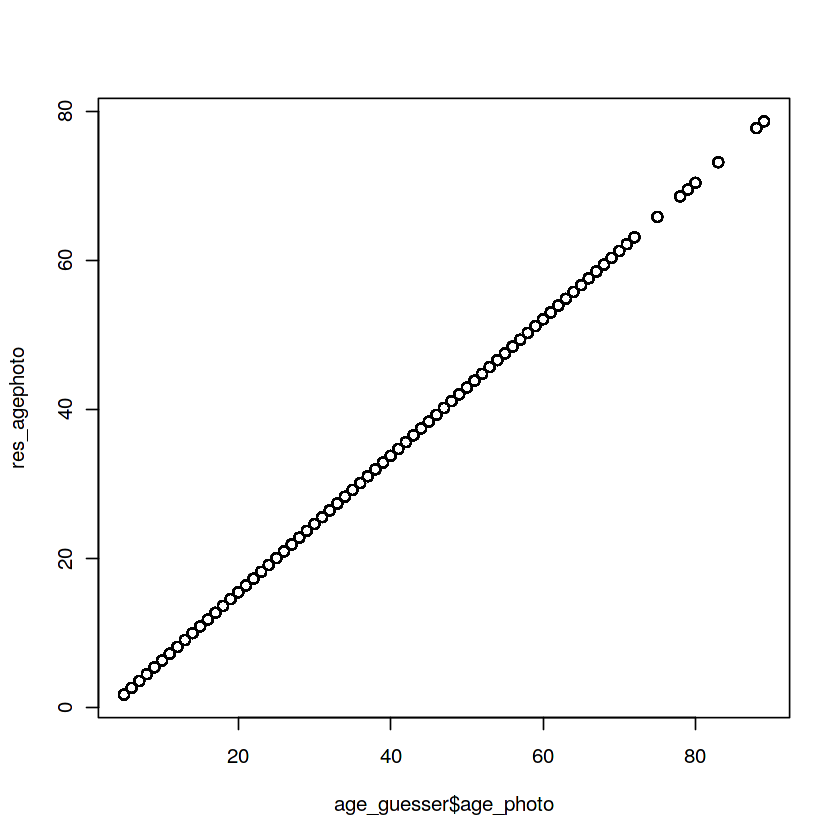

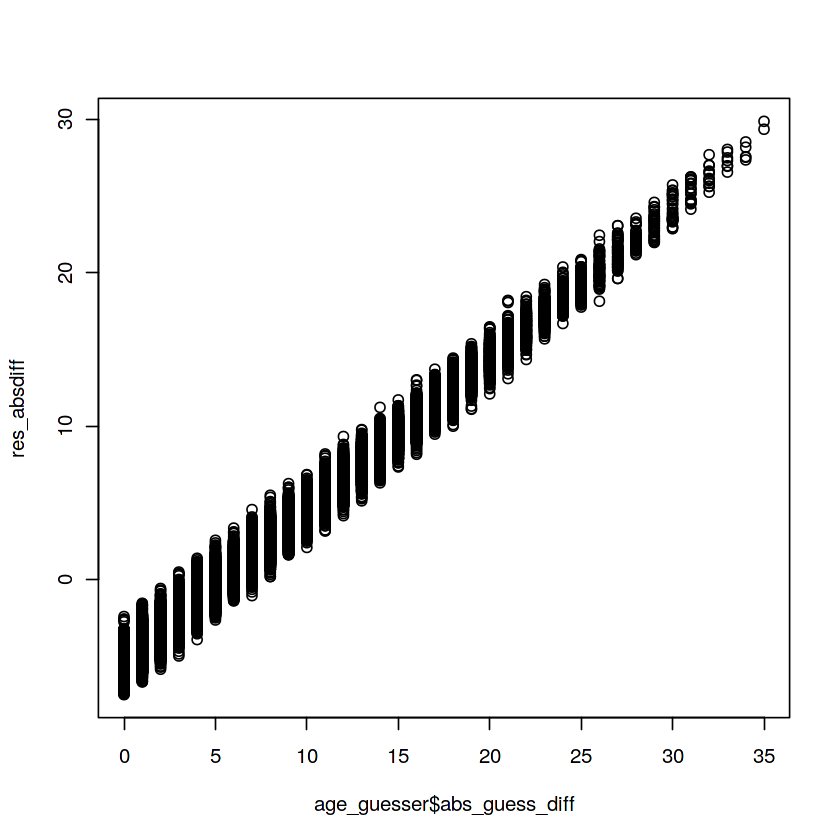

In [18]:
# plot res_agegamer vs age_gamer
pred_agegamer = predict(model_agegamer)
res_agegamer = age_guesser$age_gamer - pred_agegamer
plot(age_guesser$age_gamer, res_agegamer)

# plot res_agephoto vs age_photo
pred_agephoto = predict(model_agephoto)
res_agephoto = age_guesser$age_photo - pred_agephoto
plot(age_guesser$age_photo, res_agephoto)

#plot res_absdiff vs abs_guess_diff
pred_absdiff = predict(model_absdiff)
res_absdiff = age_guesser$abs_guess_diff - pred_absdiff
plot(age_guesser$abs_guess_diff, res_absdiff)

In [19]:
# perform exhaustive subset selection on the remaining 13 variables
regfit.full = regsubsets(abs_guess_diff ~ 
                         age_photo + gender_photo + ethnicity_photo + quality_avg + gender_gamer + ethnicity_gamer + age_diff_gamer + num_guesses + guess_year, 
                         data = modeling_df, nvmax = 15)
reg.summary = summary(regfit.full)
reg.summary
reg.summary$rsq # check for R2 vs # of variables

Subset selection object
Call: regsubsets.formula(abs_guess_diff ~ age_photo + gender_photo + 
    ethnicity_photo + quality_avg + gender_gamer + ethnicity_gamer + 
    age_diff_gamer + num_guesses + guess_year, data = modeling_df, 
    nvmax = 15)
13 Variables  (and intercept)
                        Forced in Forced out
age_photo                   FALSE      FALSE
gender_photoMale            FALSE      FALSE
ethnicity_photoBlack        FALSE      FALSE
ethnicity_photoHispanic     FALSE      FALSE
ethnicity_photoWhite        FALSE      FALSE
quality_avg                 FALSE      FALSE
gender_gamerMale            FALSE      FALSE
ethnicity_gamerBlack        FALSE      FALSE
ethnicity_gamerHispanic     FALSE      FALSE
ethnicity_gamerWhite        FALSE      FALSE
age_diff_gamer              FALSE      FALSE
num_guesses                 FALSE      FALSE
guess_year                  FALSE      FALSE
1 subsets of each size up to 13
Selection Algorithm: exhaustive
          age_photo gender_p

[1] 0.05403827 0.06109663 0.06663526 0.06846286 0.06967943 0.07067015
 [7] 0.07154639 0.07164950 0.07173479 0.07176926 0.07177470 0.07177736
[13] 0.07177980

Visualization of Subset Selection

[1] "number of variables that gives the min(ADJ R2) is"
[2] "11"                                               


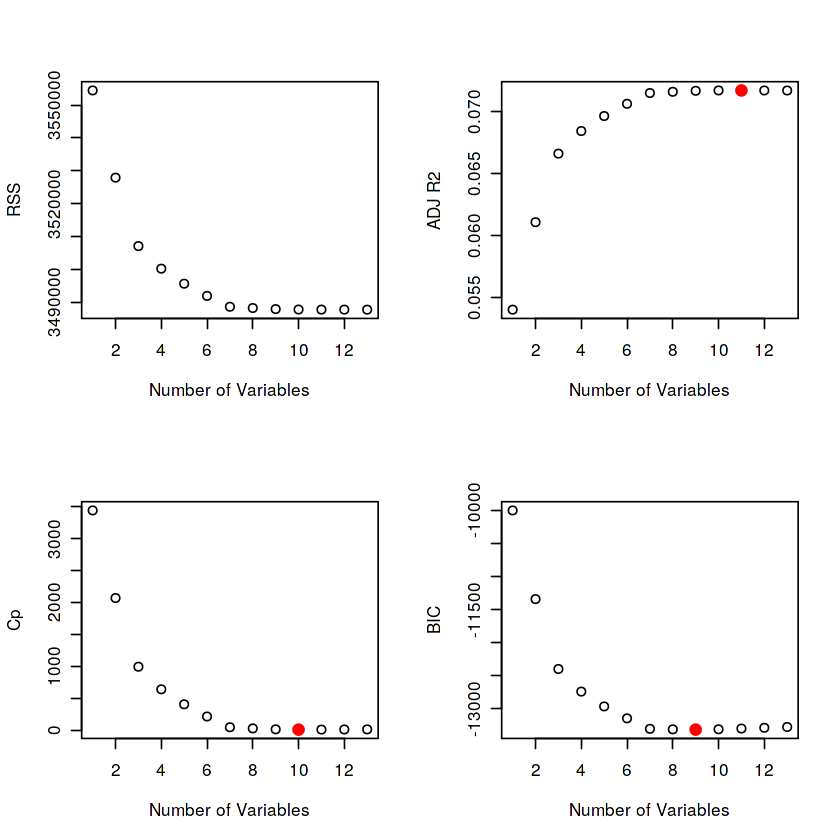

In [20]:
par(mfrow = c(2,2))
#RSS
plot(reg.summary$rss, xlab = "Number of Variables", ylab = "RSS")
#ADJ R2
plot(reg.summary$adjr2, xlab = "Number of Variables", ylab = "ADJ R2")
max_adjr2 = which.max(reg.summary$adjr2)
points(max_adjr2, reg.summary$adjr2[max_adjr2], col = 'red', cex = 2, pch = 20) # mark the max point
# CP
plot(reg.summary$cp, xlab = 'Number of Variables', ylab = "Cp")
min_cp = which.min(reg.summary$cp)
points(min_cp, reg.summary$cp[min_cp], col = 'red', cex = 2, pch = 20)
# BIC
plot(reg.summary$bic, xlab = 'Number of Variables', ylab = "BIC")
min_bic = which.min(reg.summary$bic)
points(min_bic, reg.summary$bic[min_bic], col = 'red', cex = 2, pch = 20)

print(c('number of variables that gives the min(ADJ R2) is', which.max(reg.summary$adjr2)))

# all the ADJ R2, CP, and BIC graphs sort of plateau around 11-13 for number of variables to be included in model
# maybe include just 11 variables? Or include more variables in the analysis so that we can get better answers?

Try Subset Selection with Cross-validation

In [21]:
k = 10 # set number of folds 
set.seed(5)
folds = sample(1:k, nrow(modeling_df), replace = TRUE) # sample for row number from data set as testing data
cv.errors = matrix(NA, k, 15, dimnames = list(NULL, paste(1:15))) # create a matrix to record errors for all possible of number of variable and each fold

In [22]:
# # run cross-validation
# for (j in 1:k){ # for each fold
#     best.fit = regsubsets(abs_guess_diff ~.,
#                           data = modeling_df[folds != j, ], # use the training data in current fold
#                           nvmax = 15) # perform exhaustive subset selection
#     for (i in 1:15){ # for each number of variables included in the model from subset selection
#         pred = predict(best.fit, modeling_df[folds == j, ], id = i) # predicted value using the testing data and i variables in the model
#         cv.errors[j, i] = mean((modeling_df$abs_guess_diff[folds == j] - pred) ^ 2) # record the MSE 
#     }
# }
# cv.errors

# Try Ridge
ridge is appropriate for situations where p is almost as big as n, which is not the case I have here

therefore, do not use ridge?

In [23]:
# try ridge
grid = 10 ^ seq(10, -2, length = 100)
ridge.mod = glmnet(x, y, alpha = 0, lambda = grid)

In [24]:
ridge.mod$lambda[80]
coef(ridge.mod)[, 80]

[1] 2.656088

(Intercept)             (Intercept)               age_photo 
          -3.412482e+01            0.000000e+00            5.133088e-02 
       gender_photoMale    ethnicity_photoBlack ethnicity_photoHispanic 
          -3.964831e-01            4.008819e-01           -2.285124e-01 
   ethnicity_photoWhite             quality_avg        gender_gamerMale 
          -2.786989e-01            5.152790e-01           -1.049361e-02 
   ethnicity_gamerBlack ethnicity_gamerHispanic    ethnicity_gamerWhite 
           1.226699e-01           -4.890651e-02            2.827005e-02 
         age_diff_gamer             num_guesses              guess_year 
          -7.722641e-03            2.039835e-04            1.854044e-02

# Try Lasso

In [25]:
grid = 10 ^ seq(10, -2, length = 100) # set up for lambda from 10^10 to 10^-2

Lasso

Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”


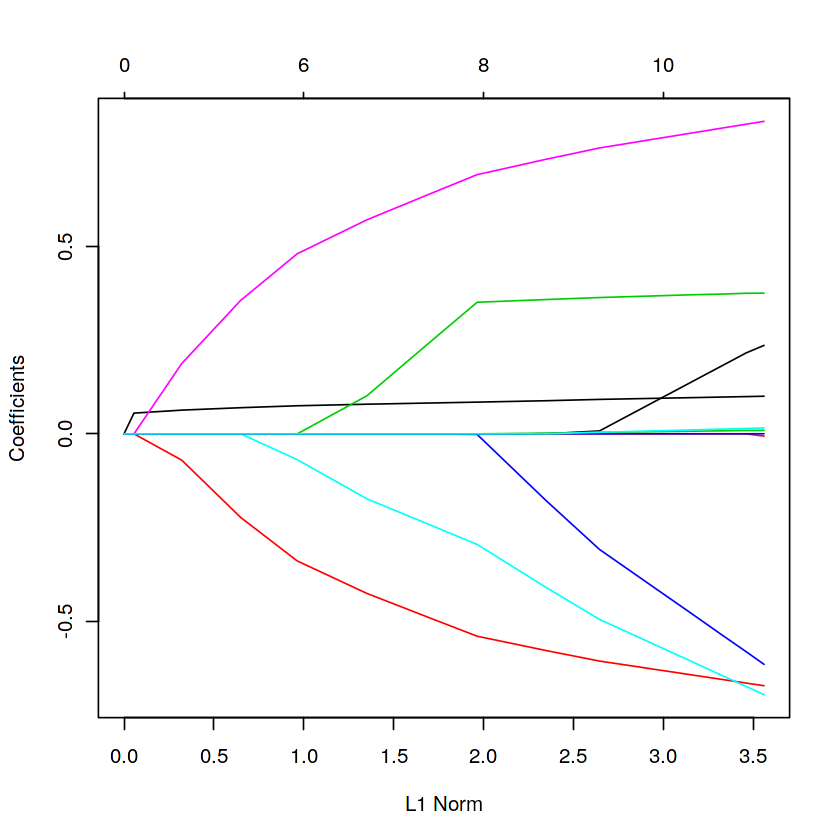

In [26]:
lasso.mod = glmnet(x[train,], y[train], alpha = 1, lambda = grid)
plot(lasso.mod)

Cross-validation

[1] 0.001907065

[1] 19.46714

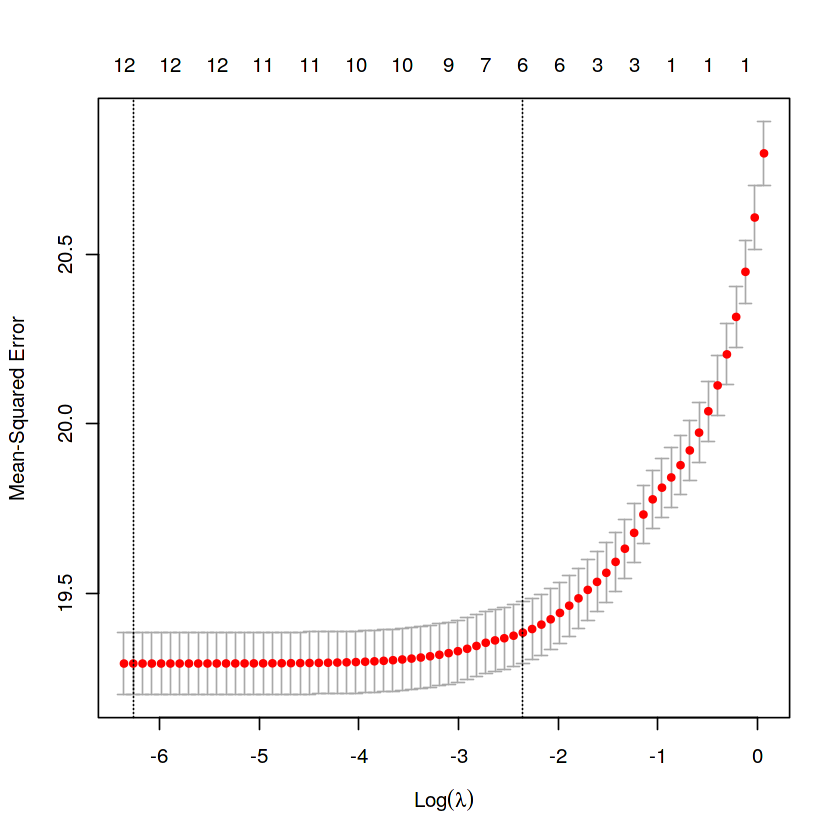

In [27]:
set.seed(5)
cv.out = cv.glmnet(x[train,], y[train], alpha = 1)
plot(cv.out)
bestlam = cv.out$lambda.min
bestlam
lasso.pred = predict(lasso.mod, s = bestlam, newx = x[test,])
mean((lasso.pred - y[test])^2)

15 x 1 sparse Matrix of class "dgCMatrix"
                                    1
(Intercept)             -2.132751e+01
(Intercept)              .           
age_photo                9.928770e-02
gender_photoMale        -6.739607e-01
ethnicity_photoBlack     3.117020e-01
ethnicity_photoHispanic -5.864414e-01
ethnicity_photoWhite    -6.749627e-01
quality_avg              8.325400e-01
gender_gamerMale        -1.588260e-03
ethnicity_gamerBlack     2.221152e-01
ethnicity_gamerHispanic  .           
ethnicity_gamerWhite     .           
age_diff_gamer           8.907899e-03
num_guesses              2.528245e-04
guess_year               1.141168e-02

Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”


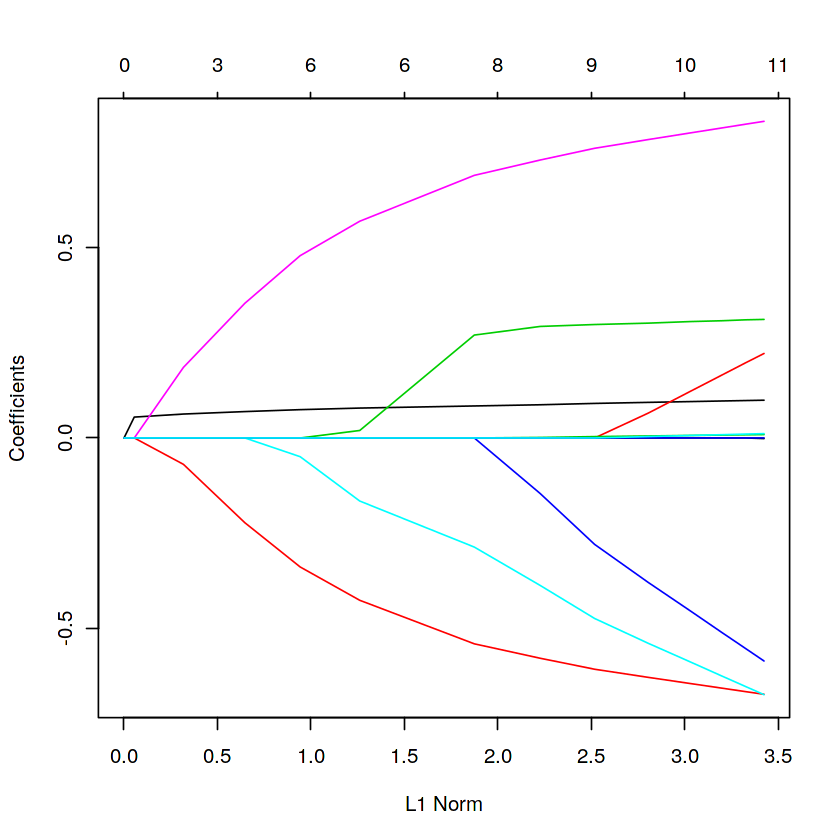

In [28]:
out = glmnet(x, y, alpha = 1, lambda = grid)
lasso.coef = predict(out,type = 'coefficients', s = bestlam)
lasso.coef
plot(out)

In [29]:
res = y[test] - lasso.pred
x_test = age_guesser[test, ]
summary(lm(res ~ age_photo, x_test))
summary(lm(res ~ age_diff_gamer, x_test))


Call:
lm(formula = res ~ age_photo, data = x_test)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.5487  -3.2200  -0.9443   2.2537  30.5958 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)  0.042895   0.059938   0.716    0.474
age_photo   -0.001516   0.001860  -0.815    0.415

Residual standard error: 4.412 on 36098 degrees of freedom
Multiple R-squared:  1.84e-05,	Adjusted R-squared:  -9.307e-06 
F-statistic: 0.664 on 1 and 36098 DF,  p-value: 0.4151



Call:
lm(formula = res ~ age_diff_gamer, data = x_test)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.6153  -3.2166  -0.9433   2.2514  30.6075 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)
(Intercept)    -0.0037760  0.0236274  -0.160    0.873
age_diff_gamer  0.0004908  0.0013014   0.377    0.706

Residual standard error: 4.412 on 36098 degrees of freedom
Multiple R-squared:  3.941e-06,	Adjusted R-squared:  -2.376e-05 
F-statistic: 0.1422 on 1 and 36098 DF,  p-value: 0.7061


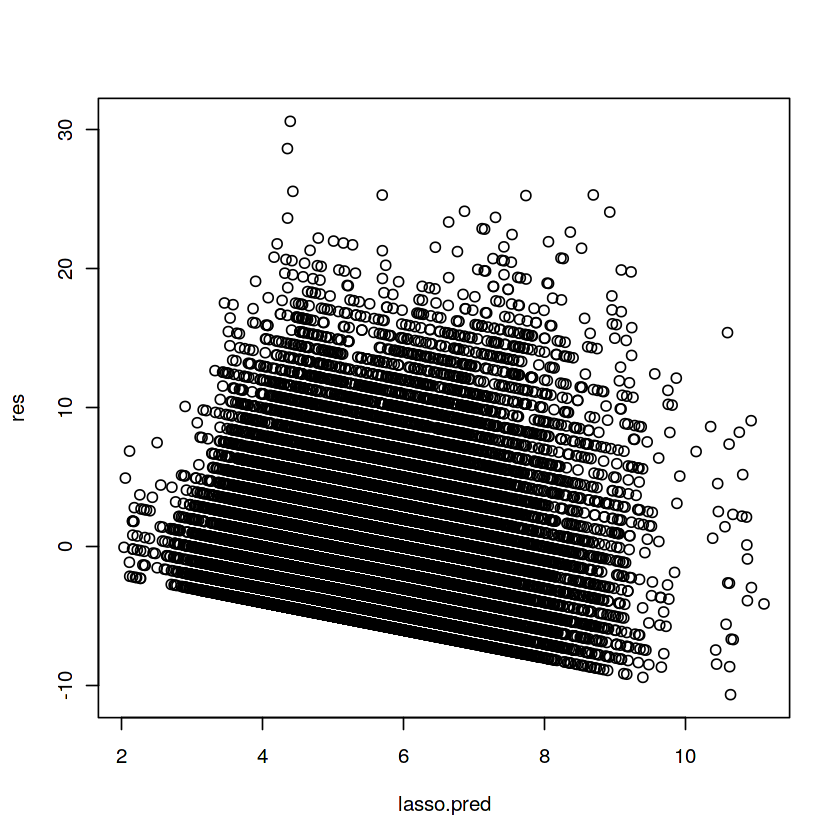

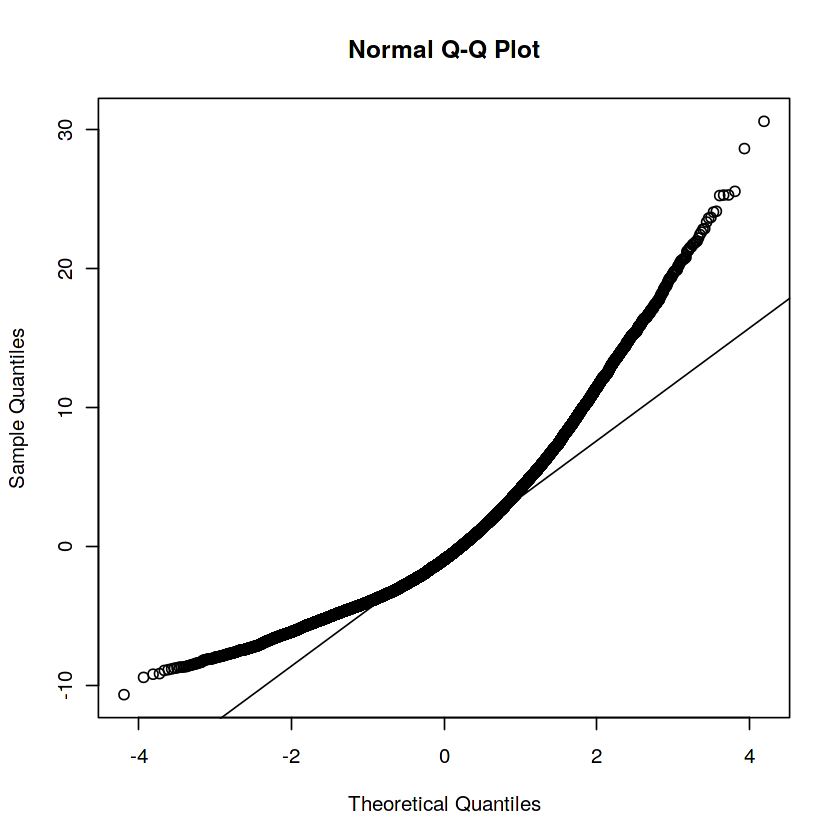

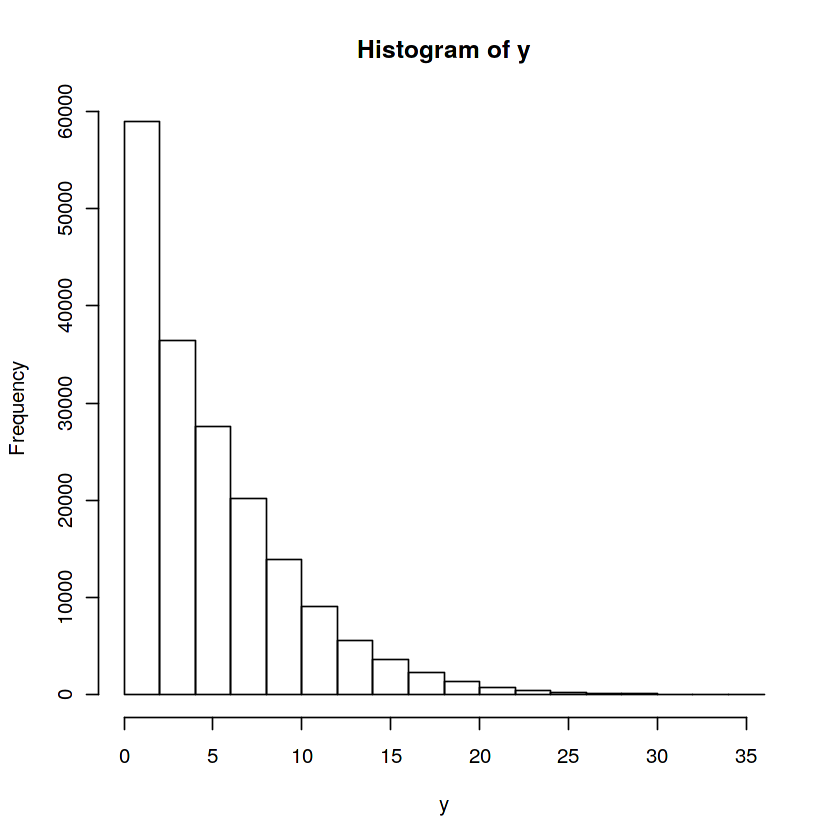

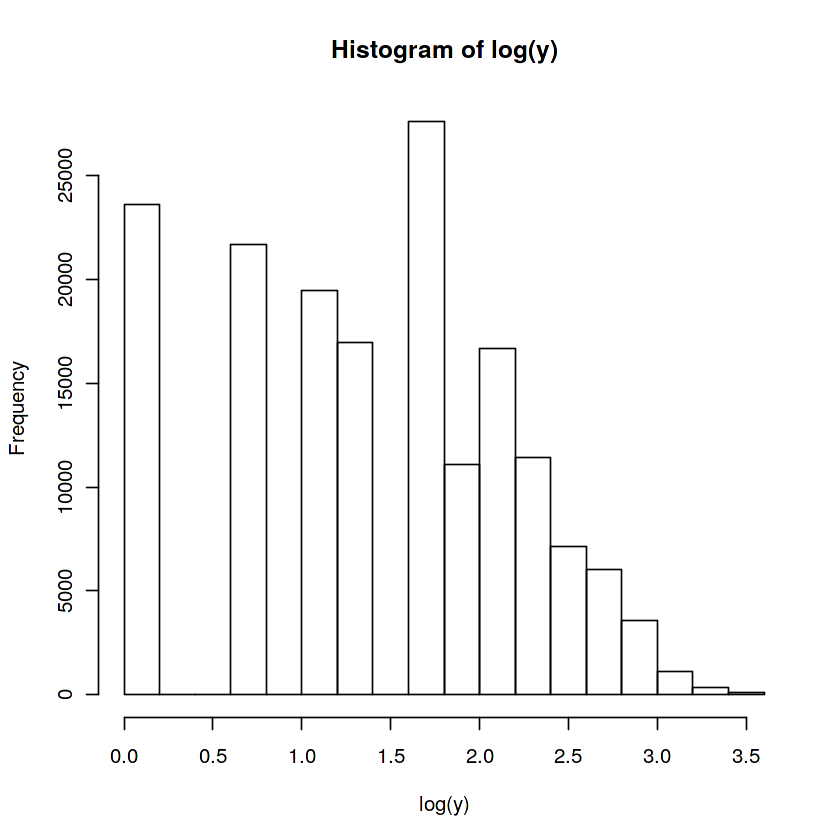

In [30]:
plot(lasso.pred, res)
qqnorm(res)
qqline(res)
hist(y) # extremely skewed distribution
hist(log(y)) # take log to make it less skewed